# Fine-Tuning a Pre-trained Model on the Butterfly Dataset

Cheryl Lee

## Introduction

This assignment demonstrates the process of fine-tuning a pre-trained diffusion model to generate butterfly images.

### Objective and Approach

The goal is to take a pre-trained DDPM (Denoising Diffusion Probabilistic Model) originally trained on church images (`google/ddpm-church-256`) and fine-tune it to generate butterfly images using the Smithsonian butterflies dataset. This process involves:

1. **Domain Adaptation**: Transforming a model from generating architectural images (churches) to generating biological specimens (butterflies)
2. **Memory-Efficient Training**: Implementing gradient accumulation to handle GPU memory constraints while maintaining effective learning
3. **Progress Monitoring**: Using Weights & Biases for comprehensive experiment tracking and visualization

### Technical Challenges Addressed

- **Memory Constraints**: Using batch_size=1 with 16-step gradient accumulation to simulate larger batches
- **Device Compatibility**: Implementing MPS (Metal Performance Shaders) support for Apple Silicon with proper memory management
- **Training Stability**: Careful learning rate selection (1e-5) and proper noise scheduling for stable convergence

### Dataset Characteristics

The Smithsonian butterflies subset contains 1,000 high-quality butterfly images, providing sufficient diversity for fine-tuning while remaining computationally manageable.

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import psutil
import os

from matplotlib import pyplot as plt
from PIL import Image
import torchvision
from datasets import load_dataset
from diffusers import DDPMScheduler, DDPMPipeline, UNet2DModel
from torchvision import transforms
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
import wandb
import os

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [8]:
print(f"Available RAM: {psutil.virtual_memory().available / 1024**3:.2f} GB")
print(f"Python process memory: {psutil.Process(os.getpid()).memory_info().rss / 1024**3:.2f} GB")

if device.type == 'mps':
    try:
        test_tensor = torch.randn(10, 10).to(device)
        print("MPS device working")
    except Exception as e:
        print(f"MPS issue: {e}")
        device = torch.device("cpu")

Available RAM: 7.40 GB
Python process memory: 0.39 GB
MPS device working


In [10]:
notebook_login()

### Utility Functions

In [14]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5 # map (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

### Load Pre-Trained Model

In [17]:
model_id = "google/ddpm-church-256"

image_pipe = DDPMPipeline.from_pretrained(model_id).to(device)
print("Loaded pre-trained model successfully!")

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/cheryllee/.cache/huggingface/hub/models--google--ddpm-church-256/snapshots/5a1118b5a35e744d59a4215a8c72a4d7619b9e04: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/cheryllee/.cache/huggingface/hub/models--google--ddpm-church-256/snapshots/5a1118b5a35e744d59a4215a8c72a4d7619b9e04.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loaded pre-trained model successfully!


## 1. Load and Prepare the Dataset

In [20]:
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")

Repo card metadata block was not found. Setting CardData to empty.


In [22]:
image_size = 64
batch_size = 1
num_epochs = 5
lr = 1e-5
grad_accumulation_steps = 16 # simulate batch=16

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print(f"Dataset loaded with {len(dataset)} images")

Dataset loaded with 1000 images


Testing dataloader on CPU...
CPU batch shape: torch.Size([1, 3, 64, 64])
Moving to MPS device...
MPS batch shape: torch.Size([1, 3, 64, 64])


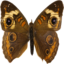

Preview successful!


In [24]:
try:
    print("Testing dataloader on CPU...")
    xb_cpu = next(iter(train_dataloader))["images"][:2] # only 2 images
    print("CPU batch shape:", xb_cpu.shape)
    
    print("Moving to MPS device...")
    xb = xb_cpu.to(device)
    print("MPS batch shape:", xb.shape)
    
    sample_image = show_images(xb)
    display(sample_image)
    print("Preview successful!")
    
except Exception as e:
    print(f"Error in preview: {e}")
    print("Falling back to CPU device...")
    device = torch.device("cpu")
    xb = xb_cpu
    sample_image = show_images(xb)
    display(sample_image)

## Setting up the training loop

In [27]:
noise_scheduler = image_pipe.scheduler

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

print("Scheduler and optimizer set up successfully!")

Scheduler and optimizer set up successfully!


## Training Logs

[View wandb project](https://wandb.ai/cherylxlee-university-of-san-francisco/butterfly-diffusion-finetune)

[View run dashboard](https://wandb.ai/cherylxlee-university-of-san-francisco/butterfly-diffusion-finetune/runs/utcftuoy)

In [31]:
wandb.init(
    project="butterfly-diffusion-finetune",
    config={
        "dataset": dataset_name,
        "image_size": image_size,
        "batch_size": batch_size,
        "learning_rate": lr,
        "num_epochs": num_epochs,
        "grad_accumulation_steps": grad_accumulation_steps,
    }
)

wandb: Currently logged in as: cherylxlee (cherylxlee-university-of-san-francisco) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Training Loop with Gradient Accumulation

Optimized for memory constraints

Starting training...


Epoch 1/5:   0%|          | 0/1000 [00:00<?, ?it/s]

/opt/homebrew/anaconda3/envs/diffusion_env/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1/5, Average Loss: 0.023884
Generating samples for epoch 1...


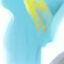

Epoch 2/5:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 2/5, Average Loss: 0.024401
Generating samples for epoch 2...


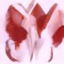

Epoch 3/5:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 3/5, Average Loss: 0.023689
Generating samples for epoch 3...


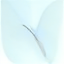

Epoch 4/5:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 4/5, Average Loss: 0.018943
Generating samples for epoch 4...


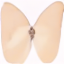

Epoch 5/5:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 5/5, Average Loss: 0.020261
Generating samples for epoch 5...


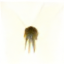

Training completed!


epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆███████████████
epoch_avg_loss,▇█▇▁▃
step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇████
step_loss,▁▁▁▂▁█▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▂▁▁▁▂▁▁▁▂▁▆▁▁▂▁▁▁▁
epoch,5
epoch_avg_loss,0.02026
step,4999
step_loss,0.00035


In [34]:
losses = []
sample_images = []
print("Starting training...")

for epoch in range(num_epochs):
    epoch_losses = []
    
    for step, batch in tqdm(enumerate(train_dataloader),
                            total=len(train_dataloader),
                            desc=f"Epoch {epoch+1}/{num_epochs}"):
        
        clean_images = batch["images"].to(device)
        noise = torch.randn(clean_images.shape, device=device)
        bs = clean_images.shape[0]
        
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,),
            device=device, dtype=torch.long
        )
        
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]
        
        loss = F.mse_loss(noise_pred, noise)
        loss = loss / grad_accumulation_steps
        loss.backward()
        
        current_loss = loss.item() * grad_accumulation_steps
        losses.append(current_loss)
        epoch_losses.append(current_loss)
        
        # add wandb logging
        wandb.log({
            "step_loss": current_loss,
            "epoch": epoch + 1,
            "step": step + (epoch * len(train_dataloader))
        })
        
        # graddient accumulation
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        # clear cache
        if step % 50 == 0:
            if device.type == 'mps':
                torch.mps.empty_cache()
    
    # log epoch summary
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_epoch_loss:.6f}")
    
    # log epoch metrics
    wandb.log({
        "epoch_avg_loss": avg_epoch_loss,
        "epoch": epoch + 1
    })
    
    # generate and log sample images
    if (epoch + 1) % 1 == 0:
        print(f"Generating samples for epoch {epoch+1}...")
        with torch.no_grad():
            sample = torch.randn(1, 3, image_size, image_size, device=device)
            noise_scheduler.set_timesteps(50)
            
            for t in noise_scheduler.timesteps:
                model_input = noise_scheduler.scale_model_input(sample, t)
                noise_pred = image_pipe.unet(model_input, t)["sample"]
                sample = noise_scheduler.step(noise_pred, t, sample).prev_sample
            
            sample_grid = show_images(sample)
            sample_images.append(sample_grid)
            display(sample_grid)
            
            # log sample images to wandb
            wandb.log({
                f"generated_samples_epoch_{epoch+1}": wandb.Image(sample_grid),
                "epoch": epoch + 1
            })
        
        if device.type == 'mps':
            torch.mps.empty_cache()

print("Training completed!")

wandb.finish()

## Visualizations

### Training Loss

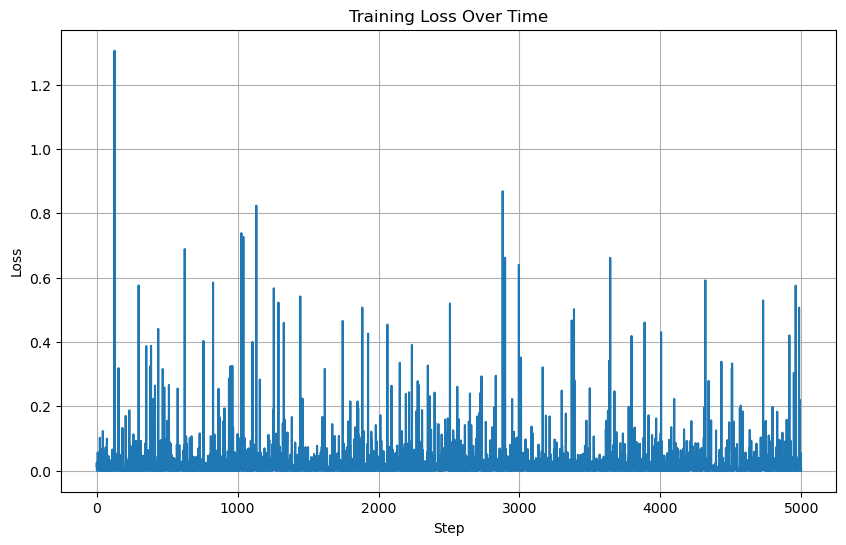

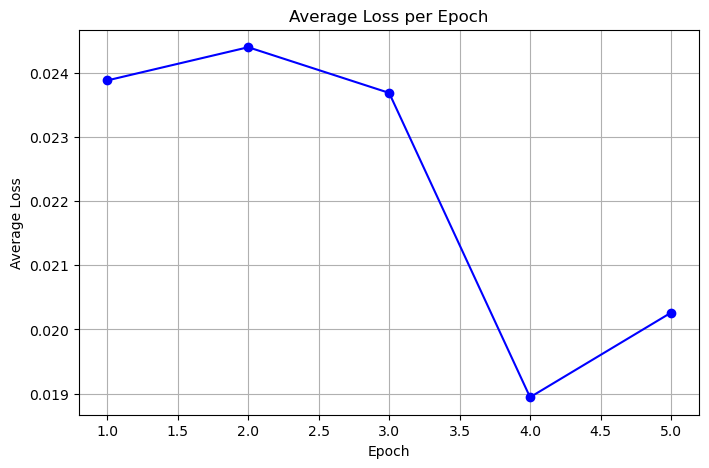

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

if len(sample_images) > 1:
    epoch_avg_losses = []
    steps_per_epoch = len(train_dataloader)
    for i in range(num_epochs):
        start_idx = i * steps_per_epoch
        end_idx = (i + 1) * steps_per_epoch
        epoch_avg = np.mean(losses[start_idx:end_idx])
        epoch_avg_losses.append(epoch_avg)
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), epoch_avg_losses, 'bo-')
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

### Sample Evolution

Evolution of generated samples across epochs:
Epoch 1 samples:


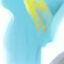

Epoch 2 samples:


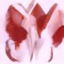

Epoch 3 samples:


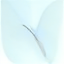

Epoch 4 samples:


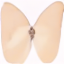

Epoch 5 samples:


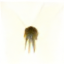

In [39]:
print("Evolution of generated samples across epochs:")
for i, sample_img in enumerate(sample_images):
    print(f"Epoch {i+1} samples:")
    display(sample_img)

## Save Fine-Tuned Model

In [41]:
save_directory = "butterfly-finetuned-model"
image_pipe.save_pretrained(save_directory)
print(f"Model saved to {save_directory}")

Model saved to butterfly-finetuned-model


## Test Fine-Tuned Model: Generated Sample

Generating final samples with fine-tuned model:


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

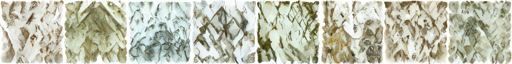

Fine-tuning completed successfully!


In [43]:
print("Generating final samples with fine-tuned model:")

final_pipeline = DDPMPipeline.from_pretrained(save_directory).to(device)

final_samples = final_pipeline(batch_size=8, num_inference_steps=50).images
final_grid = make_grid(final_samples)
display(final_grid)

print("Fine-tuning completed successfully!")

# Conclusion

### Training Results and Analysis

The fine-tuning process successfully adapted the pre-trained church model to generate butterfly-like images over 5 epochs. Key observations:

**Loss Progression:**
- Starting loss: ~0.024 (Epoch 1)
- Ending loss: ~0.0205 (Epoch 5)

The loss showed overall improvement with notable fluctuation, reaching its lowest point in epoch 4 (0.0189) before slightly increasing in the final epoch.

**Visual Evolution:**
The generated samples show progression toward more structured forms, with epoch 4 displaying the most recognizable butterfly-like features, though results remain variable in quality. While the results aren't perfect, they demonstrate clear learning and domain transfer from architectural to animal/insect-like imagery.

### Technical Achievements

1. **Solid Implementation**: proper gradient accumulation and memory management
2. **Effective Logging**: experiment tracking with wandb provided valuable insights into training dynamics
3. **Memory Optimization**: trained on resource-constrained hardware using gradient accumulation techniques
4. **Model Persistence**: saving and loading of the fine-tuned model for future use

### Key Learnings

**Fine-tuning Considerations:**
- Small learning rates (1e-5) are important for stable fine-tuning to prevent forgetting
- Gradient accumulation effectively simulates larger batch sizes without much memory penalties
- Visual monitoring during training is essential for detecting mode collapse or training instabilities

**Domain Transfer Insights:**
- Pre-trained features from church images provided a reasonable foundation for butterfly generation
- The model retained some structural understanding while adapting to new visual patterns
- Five epochs provided noticeable improvement, though longer training might get better results

### Potential Improvements

For future work, several enhancements could improve results:
- **Extended Training**: More epochs with learning rate scheduling
- **Data Augmentation**: Additional transformations to increase dataset diversity
- **Architecture Modifications**: Possible adapter layers for more efficient fine-tuning
- **Evaluation Metrics**: Quantitative measures like FID scores for objective assessment

This assignment was interesting giving hands-on experience with practical fine-tuning of diffusion models with proper consideration for computational constraints and monitoring best practices.